In [3]:
import math
import torch
from utils.optim import Optim, output, w

/Users/tim/miniconda3/envs/torch/lib/python3.9/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3491.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# SGD Optimizer

In this exercise we try to implement the vanilla SGD optimzation algorithm over a mini batch of data points. Recall that the equation for vanilla SGD was as follows:

$$
w_i = w_i - \frac{\partial{C}}{\partial{w_i}} * lr
$$

Where $C$ is the cost function and $lr$ is the learning rate.

In the below class, complete the ``` my_step()``` function, both $\frac{\partial{C}}{\partial{w_i}}$ and $lr$ are given to you. 

Hint: You can access $w_i$ through ```p.data``` and can use the [``` x.add_```](https://pytorch.org/docs/stable/tensors.html?highlight=add_#torch.Tensor.add_) function to perform the addition inplace !

In [4]:
class SGDOptimizer(Optim):
    def __init__(self, params, lr):
        defaults = dict(lr=lr)
        super(SGDOptimizer, self).__init__(params, defaults)

    def my_step(self, p, state, group):
        lr = group['lr']
        d_p = p.grad.data
        p.data.add_(-group['lr'], d_p)

Once, that's done we can try to visualise how optimzation is taking place by optimizing over a quadratic function as shown in lecture.

We see a lot of variance in the direction of the optimzation if we use a large learning rate and an inability to effectively minimise the function if we use a small learning rate !

/var/folders/1y/zxqkv74541d5n4vzm5znr9680000gn/T/ipykernel_54917/1531712688.py:9: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/python_arg_parser.cpp:1493.)
  p.data.add_(-group['lr'], d_p)


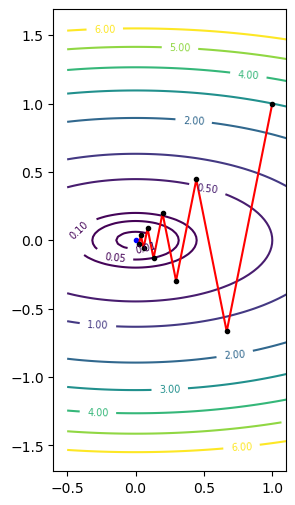

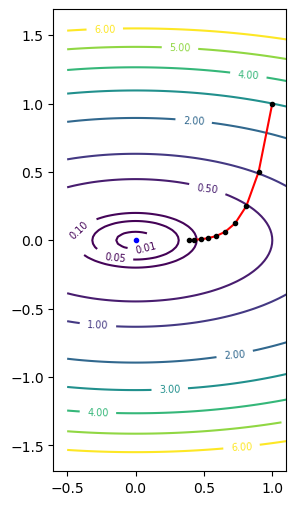

In [5]:
output(SGDOptimizer([w], lr=0.33333), fname="sgd_lr_opt_example.pdf")
output(SGDOptimizer([w], lr=0.1), fname="sgd_lr_good_example.pdf")

# Momentum

We can slightly fix the above problems by adding Momentum to our Optimizer. 

Recall from the lecture that Momentum add's a certain "force" to the direction we were travelling in before. Intuitively, from a physics perspective our optimizer has a certain momentum built in when travelling through our scary loss landscape. The benefits of momentum are as follows:

1. Accelerates Optimization. Emphirically this has been observed when we train neural networks. However, no **theory** confirms this. We can however theoretically confirm this for quadratics.
2. Noise Smoothning. Momentum can help skip over local minima and help aboid the draqstic direction changes as we had seen in vanilla SGD.

Recall the equation for SGD + Momentum was given by:

$$
v_{t+1, i} = \beta*v_{t,i} + \frac{\partial{C}}{\partial{w_{t,i}}}
$$

Here, $\beta$ is a hyperparamter we have to tune. A popular choice of $\beta$ is 0.9 which intuitively says that we care more about the past directions of the gradient than the direction indicated in the current step. Using $v_i$, our weight update step becomes as follows:
$$
w_{t+1,i} = w_{t,i} - v_{t+1,i} * lr
$$


**Note**: $v_{t, i}$ for $t = 0$ is 0.


In [6]:
class SGDMomentumOptimizer(Optim):
   
    def __init__(self, params, lr, momentum):
        defaults = dict(lr=lr,momentum=momentum)
        super(SGDMomentumOptimizer, self).__init__(params, defaults)

    def my_step(self, p, state, group):
        lr = group['lr']
        momentum = group['momentum']
        d_p = p.grad.data
        
        if 'v' not in state:
            state['v'] = torch.clone(d_p).detach()
        else:
            state['v'] = d_p + momentum*state['v']

        d_p = state['v']
        p.data.add_(-group['lr']*d_p)

Let's visualise the performance of this optimizer below. We see that SGD + momentum can perform  better after tuning the learning rate and momentum !

An important point to consider when measuring the effect of momentum is to change the learning rate by a similiar amount. This can be achieved by something like this:

$$
lr_{new} = lr_{old} * (1 - m)
$$

Unfortunately, tuning these hyper params is a real part of training neural nets effectively :(

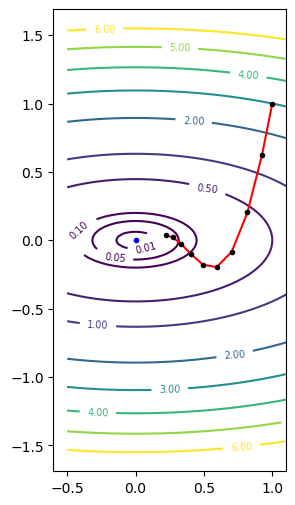

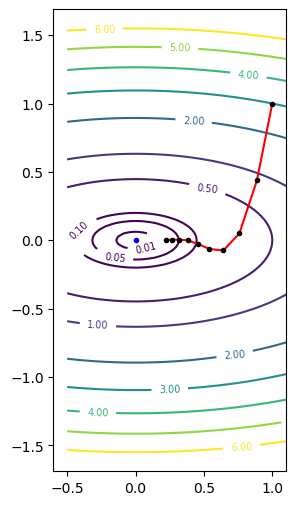

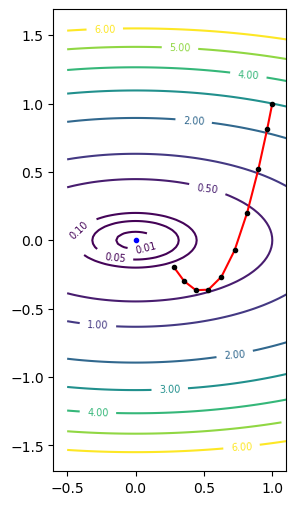

In [7]:
output(SGDMomentumOptimizer([w], lr=0.15*(1-0.5), momentum=0.5), nsteps=10, fname="sgd_50mom_example.pdf")
output(SGDMomentumOptimizer([w], lr=0.15*(1-0.25), momentum=0.25), nsteps=10, fname="sgd_25mom_example.pdf")
output(SGDMomentumOptimizer([w], lr=0.15*(1-0.75), momentum=0.75), nsteps=10, fname="sgd_75mom_example.pdf")

In the below example, we can see a much obvious positive effect of using momentum if we inject noise (increase non convexity) in our loss landscape. Momentum is able to ignore this noise more effectively than vanilla SGD.

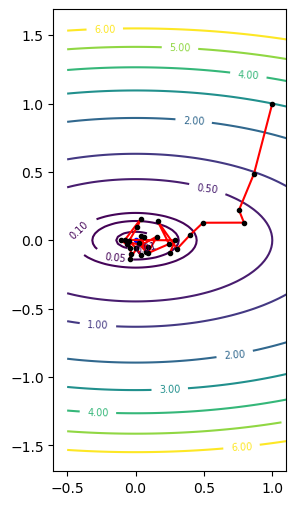

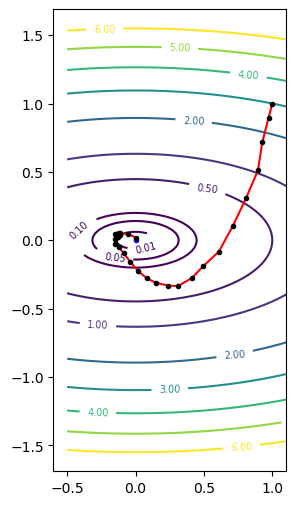

In [8]:
output(SGDMomentumOptimizer([w], lr=0.1, momentum=0.0), nsteps=30, noise=1.0, fname="sgd_noise_example.pdf")
output(SGDMomentumOptimizer([w], lr=0.1*(1-0.8), momentum=0.8), nsteps=30, noise=1.0, fname="sgd_mom_noise_example.pdf")


# RMSProp

Now, we shall move into the realm of adaptive optimizers that try to do something clever by taking into account the past movement of the gradient for each weight. 

The intuition is that different layers of a neural network learn at different rates. For example, for a big convolutional net, the output is less sensitive to the pertubations of the weights of the earlier layers and more sensitive to pertubations to the weights of the later layers.

Therefore, in some networks using a larger learning rate for earlier layers and a smaller learning rate for later layers could aid in faster and better convergence. 

One such idea to vary the learning rate is introduced by RMSProp. The key ideas was to normalise the learning rate of each weight by the gradients **Root Mean Square**.

$$
v_{t+1, i} = \alpha * v_{t,i} + (1 - \alpha) * (\frac{\partial{C}}{\partial{w_{t,i}}})^2
$$
Here, $v$ is simply the *moving average* of the root mean square of the gradient. We use $v$ in our gradient update rule as follows:
$$
w_{t+1,i} = w_{t, i} - \frac{lr}{\sqrt{v_{t+1,i}} + \epsilon}
$$


**Hint:** Use the state dictionary to hold the buffers for $v$. Keep in mind that originally the value of v should be 0 and the tensor should be the same shape as that of ```p.grad```.

In [9]:
class RMSPropOptimizer(Optim):
   
    def __init__(self, params, lr, alpha):
        self.eps = 1e-8
        defaults = dict(lr=lr,alpha=alpha)
        super(RMSPropOptimizer, self).__init__(params, defaults)

    def my_step(self, p, state, group):
        lr = group['lr']
        alpha = group['alpha']
        grad = p.grad.data
        
        if 'v' not in state:
            state['v'] = torch.zeros_like(p.data)

        state['v'] = (1-alpha)*torch.pow(grad,2) + alpha*state['v']
        grad.div_(torch.sqrt(state['v']) + self.eps)
        p.data.add_(-group['lr']*grad)

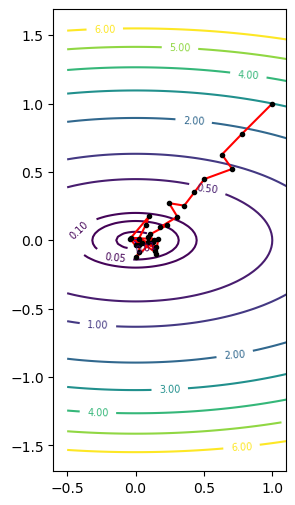

In [10]:
output(RMSPropOptimizer([w], lr=0.1, alpha=0.8), nsteps=30, noise=1.0, fname="rmsprop_noise_example.pdf")

# Adam Optimizer

What is Adam ? It is simply RMSProp + Momentum.

The root mean square term is calculated exactly like as before
$$
v_{t+1, i} = \alpha * v_{t,i} + (1 - \alpha) * (\frac{\partial{C}}{\partial{w_{t,i}}})^2
$$
The momentum update is given as below, it is roughly equivalent to the momentum in SGD.
$$
m_{t+1, i} = \beta * m_{t,i} + (1 - \beta) * (\frac{\partial{C}}{\partial{w_{t,i}}})
$$
Finally, the weight update is given as follows:
$$
w_{t+1,i} = w_{t, i} - \frac{lr*m}{\sqrt{v_{t+1,i}} + \epsilon}
$$

Is that it ? Well, not quite. Just plugging this in will give us nan values, to correct for this we do something called bias scaling. The idea behind bias scaling is simple. which just keeps the
moving averages **unbiased** during early iterations. The algorithm quickly approaches the above steady state form.

The equation of Adam with bias scaling is given as follows:

$$
b_1 = (1 - \beta)^t
$$

$$
b_2 = (1 - \alpha)^t
$$

where $t$ is the step number of the gradient update. We use these values to modify our final weight update as follows:

$$
w_{t+1,i} = w_{t, i} - lr*\frac{\frac{m}{ b_1}}{\sqrt{\frac{v_{t+1,i}}{b_2}} + \epsilon}
$$

And that's Adam !

**Hint:** The torch operator [addcdiv_](https://pytorch.org/docs/stable/tensors.html?highlight=addcdiv_#torch.Tensor.addcdiv_) might be of some interest. Inplace ops are an automatic perf win !


In [11]:
import math 

class AdamOptimizer(Optim):
   
    def __init__(self, params, lr, alpha, momentum):
        self.eps = 1e-8

        defaults = dict(lr=lr, alpha=alpha, momentum=momentum)
        super(AdamOptimizer, self).__init__(params, defaults)

    def my_step(self, p, state, group):
        lr = group['lr']
        alpha = group['alpha']
        momentum = group['momentum']
        grad = p.grad.data

        if len(state) == 0:
          state['step'] = 0
          state['m'] = torch.zeros_like(p.data)
          state['v'] = torch.zeros_like(p.data)

        state['step'] += 1
        m, v = state['m'], state['v']

        bias_correction1 = 1 - momentum ** state['step']
        bias_correction2 = 1 - alpha ** state['step']

        m.mul_(momentum).add_(1 - momentum, grad)

        v.mul_(alpha).addcmul_(1 - alpha, grad, grad)

        denom = (v.sqrt() / math.sqrt(bias_correction2)).add_(self.eps)
        step_size = lr / bias_correction1
        p.data.addcdiv_(-step_size, m, denom)

As we can see, the updates are much smoother than RMSProp and we get the same benefits of adaptive learning rates !

The situation is not as clear when we train deep neural nets. Remember, for some problems a well tuned SGD + Momentum outperforms many of the state of the art optimization techniques :)

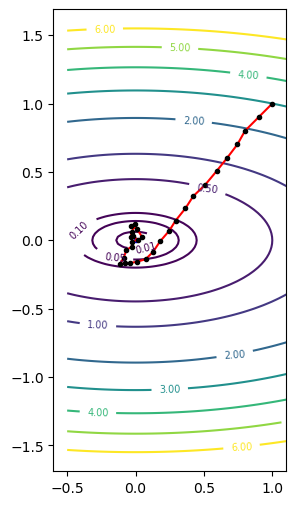

In [12]:
output(AdamOptimizer([w], lr=0.1, alpha=0.7, momentum=0.7), nsteps=30, noise=1.0, fname="adam_noise_example.pdf")